# Models

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import sys
import numpy
import math
numpy.set_printoptions(threshold=sys.maxsize)

In [2]:
# load pre porcessed data
df = pd.read_csv('../prepross_data/data.csv')


#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


### for SH events prediction pre processing


In [4]:
y_label = 'Pt_SevHypoEver' 
# possible labels Pt_SevHypoEver, SHSeizComaPast12mos, DKAPast12mos, Depression, DiabNeuro, DKADiag

In [5]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition
def fill_y_label(row):

    if(math.isnan(row['Pt_SevHypoEver'])):
        if(row['NumSHSeizComaPast12mos'] >= 1) or (row['Pt_v3NumSHSeizComa'] >= 1) or (row['SHSeizComaPast12mos'] == 0):
            row['Pt_SevHypoEver'] = 0
        else:
            row['Pt_SevHypoEver'] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [6]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# {'1.Yes': 0, '2.No': 1, "3.Don't know": 2}

get_possible_vals_with_nan(df, y_label)

if(y_label == 'SHSeizComaPast12mos' ):
#     df.drop(['NumSHSeizComaPast12mos','Pt_v3NumSHSeizComa','NumSHSeizComa', 'Pt_SevHypoEver'], inplace=True, axis=1) # add SHSeizComaPast12mos
    df.drop(['NumSHSeizComaPast12mos','Pt_v3NumSHSeizComa'], inplace=True, axis=1) # add SHSeizComaPast12mos
    df[y_label] = df[y_label].replace({2.0: 1.0})

elif (y_label == 'Pt_SevHypoEver'):
#     df.drop(['NumSHSeizComaPast12mos','Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1) # add SHSeizComaPast12mos
    df[y_label] = df[y_label].replace({2.0: 0.0})


# Divide Dataset

In [7]:
# filter only the features used in paper diagDuration,

selected_features = True

# if(selected_features):
#     df = df[['AgeAtConsent','diagDuration','HbA1c', 'Gender', 'Pt_RaceEth','Pt_AnnualInc', 'Pt_InsPriv', 'Pt_EduLevel',
#          'InsulinDeliv','Pt_InsCarbRat', 'relative_T1D', 'Pt_Smoke', y_label,
#          'MajorLifeStressEvent', 'Weight', 'Height']] # Pt_SevHypoEver ,SHSeizComaPast12mos, DKAPast12mos

if(selected_features):
    df = df[['diagDuration','HbA1c','Pt_AnnualInc', 'Pt_InsPriv', 'education_level',
         'InsulinDeliv','Pt_InsCarbRat', 'Pt_Smoke', y_label,
         'MajorLifeStressEvent']] # Pt_SevHypoEver ,SHSeizComaPast12mos, DKAPast12mos


# if(selected_features):
#     df = df[['Diab_dur_greater','HbA1C_SH','Pt_AnnualInc', 'Pt_InsPriv', 'Pt_EduLevel','diagDuration'
#              ,y_label]] # SHSeizComaPast12mos



In [8]:
if(not selected_features):
    df=df.drop('PtID', axis = 1)

<AxesSubplot:>

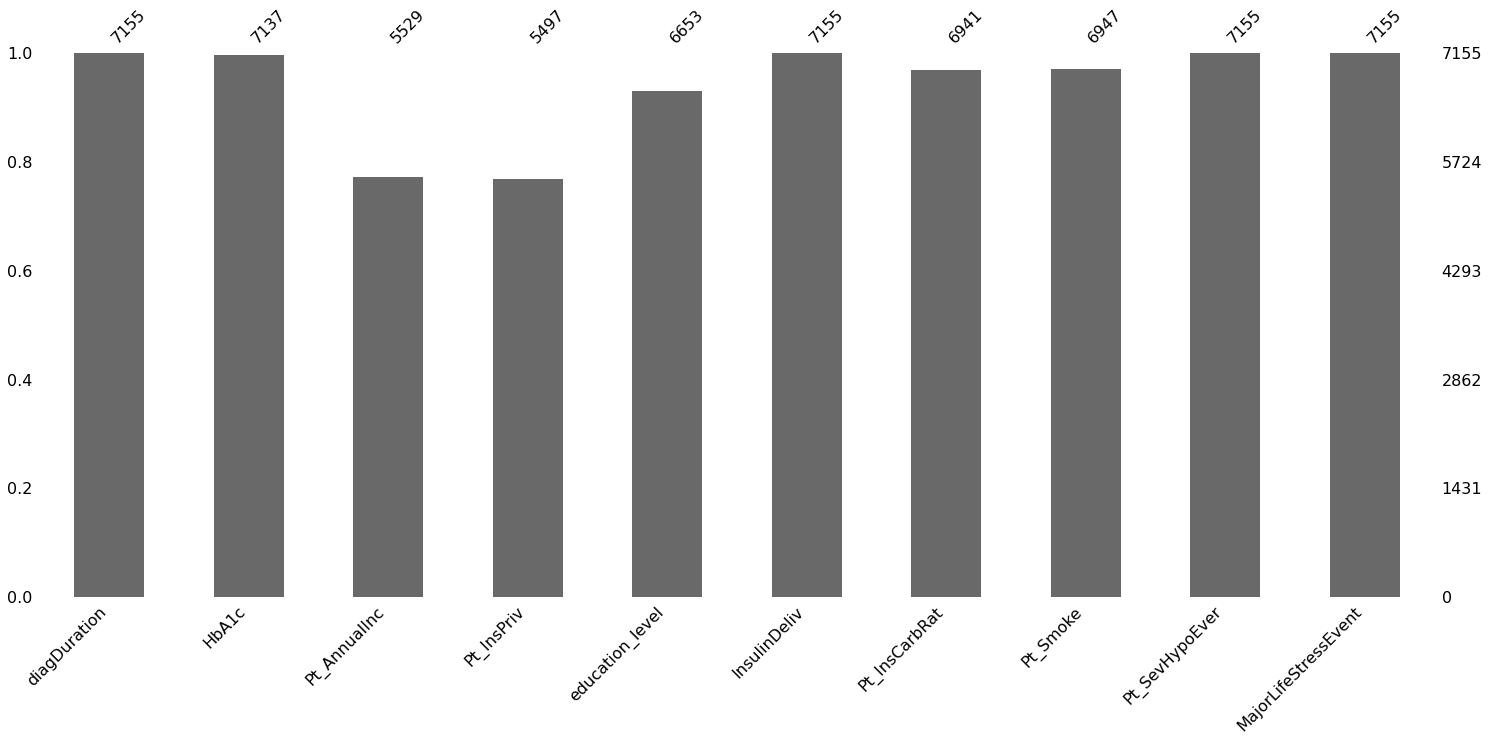

In [9]:
import missingno as msno
msno.bar(df)

In [10]:
df['Pt_InsPriv'] = df['Pt_InsPriv'].fillna(0)
df['Pt_InsPriv'].unique()

array([1., 0.])

> with imputation gives little more better results than dropping the rows if there are null values

In [11]:
# df = df.dropna()
# df

In [12]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y


X, Y = divide_data(df, y_label)


In [13]:
# pd.set_option('display.max_columns', None)  # or 1000
# pd.set_option('display.max_rows', None)  # or 1000
# pd.set_option('display.max_colwidth', -1)  # or 199



# Feature Selection

In [14]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
seed(42)
import tensorflow as tf
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

2021-12-31 07:38:48.614385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-31 07:38:48.614418: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [15]:
shape = np.shape(X) 

if(selected_features):
    feature = shape[1] 
else:
    feature = shape[1] 
    
n_classes = 2

feature

9

In [16]:

# fill with 0 - if data not available probably patient has not that medical condition
if(y_label == 'SHSeizComaPast12mos' or y_label == 'DKADiag' or y_label == 'Pt_SevHypoEver' or y_label == 'DKAPast12mos'):
    Y = Y.fillna(1)
else:
    Y = Y.fillna(0)


In [17]:

seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)
# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [18]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print(unique, counts)


unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print(unique_test, counts_test)


[0. 1.] [1548 3818]
[0. 1.] [ 516 1273]


### XGB with missing values

Cross Validation accuracy scores: [0.70018622 0.68901304 0.70391061 0.69273743 0.70763501 0.70204842
 0.70895522 0.71455224 0.72014925 0.69589552]
Cross Validation accuracy: 0.704 +/- 0.009

 
 ===========   Train Dataset    =============
76.31382780469623


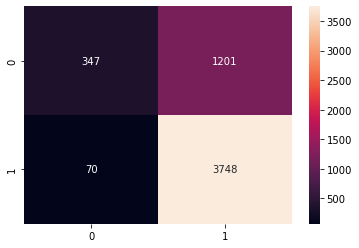

              precision    recall  f1-score   support

         0.0       0.83      0.22      0.35      1548
         1.0       0.76      0.98      0.86      3818

    accuracy                           0.76      5366
   macro avg       0.79      0.60      0.60      5366
weighted avg       0.78      0.76      0.71      5366

Accuracy of XGB on training set: 0.76


 ===========   Test Dataset    =============
72.10732252655114
              precision    recall  f1-score   support

         0.0       0.56      0.16      0.24       516
         1.0       0.74      0.95      0.83      1273

    accuracy                           0.72      1789
   macro avg       0.65      0.55      0.54      1789
weighted avg       0.68      0.72      0.66      1789



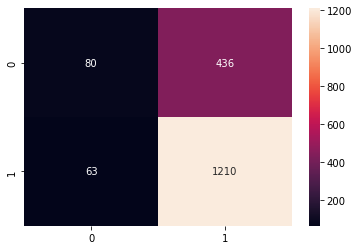

Accuracy of XGB classifier on test set: 0.72


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.15503876 0.9505106 ]
average accuracy:  0.5527746822801537


In [19]:
# xgboost - train with missing values

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model=XGBClassifier(
        use_label_encoder=False, eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )
                   
model.fit(X_train,Y_train)

# cross validation
scores = cross_val_score(model, X=X_train, y=Y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))


xgb_pred=model.predict(X_test)
xgb_pred_train=model.predict(X_train)


# proba = model.predict_proba(X_test)
# print(proba)


print("\n \n ===========   Train Dataset    =============")

print(accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, xgb_pred_train))

train_acc = model.score(X_train, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")



print(accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy: ', acc)
print('average accuracy: ',  np.sum(acc)/2)

<AxesSubplot:>

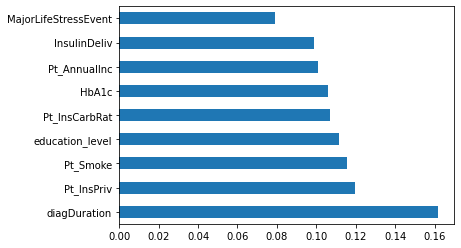

In [20]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns[0:162])
feat_importances.nlargest(20).plot(kind='barh')

# Imputations

In [21]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')
# imputeX = IterativeImputer(max_iter=5, random_state=0)

X_train = imputeX.fit_transform(X_train)


In [22]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)


# Scale data

In [23]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
select[0] = pd.DataFrame(scaler.fit_transform(X_train))
select[1] = Y_train
select[2] = pd.DataFrame(scaler.transform(X_test))

# Feature selection

In [24]:
# TODO

# def select_features(select, feature):
#     selected = {}
#     fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx



In [25]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])
        
    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [26]:
# Feature selection
selected, fs, idx = select_features(select, feature)

/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:39:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [27]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)

Index(['diagDuration', 'HbA1c', 'Pt_AnnualInc', 'Pt_InsPriv',
       'education_level', 'InsulinDeliv', 'Pt_InsCarbRat', 'Pt_Smoke',
       'MajorLifeStressEvent'],
      dtype='object')
(7155, 9)


In [28]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)

In [29]:
X_train

,diagDuration,HbA1c,Pt_AnnualInc,Pt_InsPriv,education_level,InsulinDeliv,Pt_InsCarbRat,Pt_Smoke,MajorLifeStressEvent
0,1.015010,1.133667,-1.063759,-1.827956,0.349203,-0.726216,-0.452044,-0.617657,0.982633
1,0.109434,-0.614464,0.458511,0.547059,-0.267999,2.242832,-0.452044,-0.617657,-1.017674
2,-0.847079,-0.052073,0.839078,0.547059,1.583607,-0.726216,-0.452044,-0.617657,-1.017674
3,-0.647471,-0.015621,-0.302624,0.547059,0.349203,-0.726216,-0.452044,-0.617657,-1.017674
4,-0.676472,-0.832130,1.600213,-1.827956,0.349203,0.758308,-0.452044,-0.617657,0.982633
...,...,...,...,...,...,...,...,...,...
5361,1.036058,0.803461,-0.302624,0.547059,0.349203,-0.726216,-0.452044,-0.617657,-1.017674
5362,-0.285271,-1.736123,-1.063759,0.547059,0.349203,-0.726216,-0.452044,-0.617657,-1.017674
5363,-0.172622,0.097503,-1.063759,0.547059,-0.267999,-0.726216,4.019230,-0.617657,0.982633
5364,-0.066351,0.222969,1.219646,-1.827956,0.966405,0.758308,-0.452044,1.278422,-1.017674


Cross Validation accuracy scores: [0.71880819 0.7113594  0.72998138 0.70577281 0.70577281 0.71880819
 0.70708955 0.71828358 0.71828358 0.70895522]
Cross Validation accuracy: 0.714 +/- 0.007

 
 ===========   Train Dataset    =============
72.1393961982855


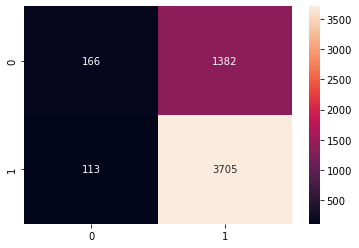

              precision    recall  f1-score   support

         0.0       0.59      0.11      0.18      1548
         1.0       0.73      0.97      0.83      3818

    accuracy                           0.72      5366
   macro avg       0.66      0.54      0.51      5366
weighted avg       0.69      0.72      0.64      5366

Accuracy of adaboost on training set: 0.72


 ===========   Test Dataset    =============
72.10732252655114


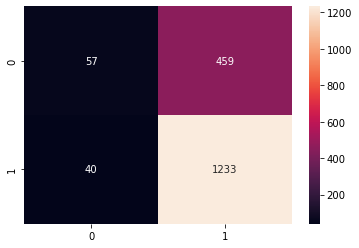

              precision    recall  f1-score   support

         0.0       0.59      0.11      0.19       516
         1.0       0.73      0.97      0.83      1273

    accuracy                           0.72      1789
   macro avg       0.66      0.54      0.51      1789
weighted avg       0.69      0.72      0.65      1789

Accuracy of adaboost classifier on test set: 0.72


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.11046512 0.96857816]
average accuracy:  0.5395216390507682


In [30]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

adaboost = AdaBoostClassifier(random_state=0, learning_rate=0.05, n_estimators=1000, algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# cross validation
scores = cross_val_score(adaboost, X=X_train, y=Y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

adaboost.fit(X_train, Y_train)
pred=adaboost.predict(X_test)

pred_train=adaboost.predict(X_train)

# proba = adaboost.predict_proba(X_test)
# print(proba)


print("\n \n ===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_ada_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_ada_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = adaboost.score(X_train, Y_train)
print('Accuracy of adaboost on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")

print(accuracy_score(Y_test, pred)*100)

confusion_matrix_ada = confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_ada, annot=True,fmt='g')
plt.show()

print(classification_report(Y_test, pred))
test_acc = adaboost.score(X_test, Y_test)
print('Accuracy of adaboost classifier on test set: {:.2f}'
     .format(test_acc))


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_ada.diagonal()/confusion_matrix_ada.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))


<AxesSubplot:>

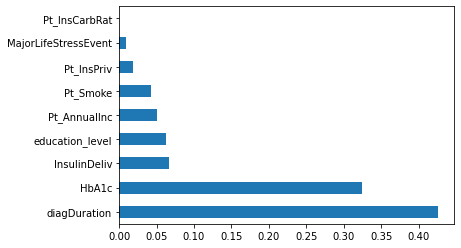

In [31]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(feature).plot(kind='barh')

# Model - XGB

Cross Validation accuracy scores: [0.70577281 0.70018622 0.70949721 0.70204842 0.70949721 0.70018622
 0.70708955 0.7108209  0.7238806  0.67350746]
Cross Validation accuracy: 0.704 +/- 0.012

 
 ===========   Train Dataset    =============
76.10883339545285


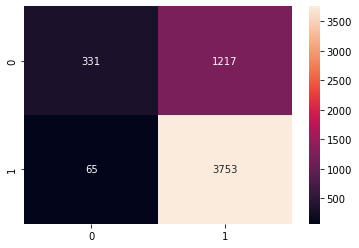

              precision    recall  f1-score   support

         0.0       0.84      0.21      0.34      1548
         1.0       0.76      0.98      0.85      3818

    accuracy                           0.76      5366
   macro avg       0.80      0.60      0.60      5366
weighted avg       0.78      0.76      0.71      5366

Accuracy of XGB on training set: 0.76


 ===========   Test Dataset    =============
72.3868082727781
              precision    recall  f1-score   support

         0.0       0.58      0.15      0.24       516
         1.0       0.74      0.96      0.83      1273

    accuracy                           0.72      1789
   macro avg       0.66      0.55      0.54      1789
weighted avg       0.69      0.72      0.66      1789



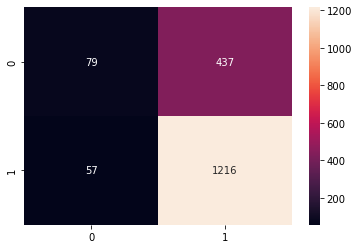

Accuracy of XGB classifier on test set: 0.72


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.15310078 0.95522388]
average accuracy:  0.5541623278954066


In [32]:
# xgboost - train with missing values
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb_impute=XGBClassifier(
    use_label_encoder=False, eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
        )
        
xgb_impute.fit(X_train,Y_train)

# cross validation
scores = cross_val_score(xgb_impute, X=X_train, y=Y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))


xgb_pred=xgb_impute.predict(X_test)
xgb_pred_train=xgb_impute.predict(X_train)


# proba = xgb_impute.predict_proba(X_test)
# print(proba)


print("\n \n ===========   Train Dataset    =============")

print(accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, xgb_pred_train))

train_acc = xgb_impute.score(X_train, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")



print(accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')
print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = xgb_impute.score(X_test, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))



<AxesSubplot:>

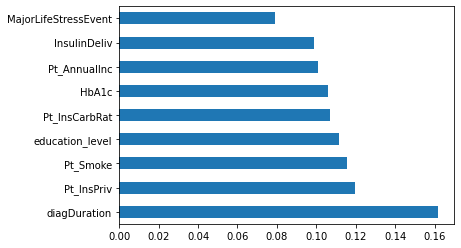

In [33]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 2 - Random forest

Cross Validation accuracy scores: [0.63128492 0.62942272 0.63687151 0.62383613 0.6405959  0.62383613
 0.60634328 0.64738806 0.5988806  0.62313433]
Cross Validation accuracy: 0.626 +/- 0.014
===========   Train Dataset    =============
76.27655609392471


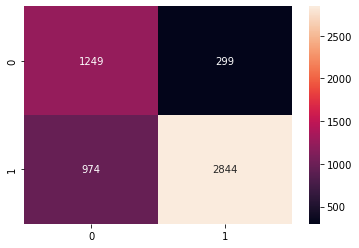

              precision    recall  f1-score   support

         0.0       0.56      0.81      0.66      1548
         1.0       0.90      0.74      0.82      3818

    accuracy                           0.76      5366
   macro avg       0.73      0.78      0.74      5366
weighted avg       0.81      0.76      0.77      5366

Accuracy of XGB on training set: 0.76


 ===========   Test Dataset    =============
62.82839575181666
              precision    recall  f1-score   support

         0.0       0.40      0.61      0.48       516
         1.0       0.80      0.64      0.71      1273

    accuracy                           0.63      1789
   macro avg       0.60      0.62      0.60      1789
weighted avg       0.69      0.63      0.64      1789



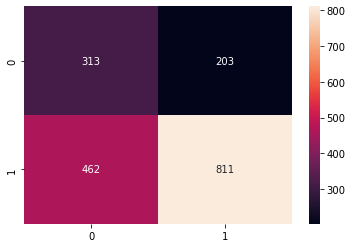

Accuracy of random forest classifier classifier on test set: 0.63


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.60658915 0.63707777]
average accuracy:  0.6218334581681555


In [34]:
#  random forest classifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


rf=RandomForestClassifier(max_depth=10,
                             n_estimators = 20,
                             criterion = 'entropy', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced_subsample', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.0001,
                             random_state=0)

# cross validation
scores = cross_val_score(rf, X=X_train, y=Y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))


rf.fit(X_train,Y_train)

pred=rf.predict(X_test)
pred_train=rf.predict(X_train)


# proba = rf.predict_proba(X_test)

# print(proba)

print("===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_rfc_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_rfc_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = rf.score(X_train, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")


print(accuracy_score(Y_test, pred)*100)

confusion_matrix_rf = confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_rf, annot=True, fmt='g')

print(classification_report(Y_test, pred))
plt.show()

test_acc = rf.score(X_test, Y_test)
print('Accuracy of random forest classifier classifier on test set: {:.2f}'
     .format(test_acc))

print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_rf.diagonal()/confusion_matrix_rf.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))

<AxesSubplot:>

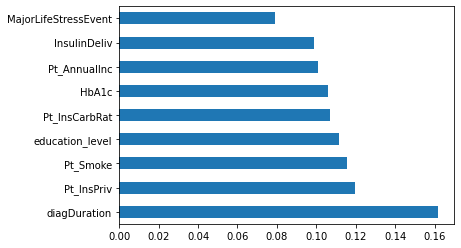

In [35]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 3 LogisticRegression

/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/kali/.local/li

Cross Validation accuracy scores: [0.6461825  0.63314711 0.62011173 0.62197393 0.65735568 0.6405959
 0.61940299 0.64925373 0.6380597  0.60074627]
Cross Validation accuracy: 0.633 +/- 0.016

 
 ===========   Train Dataset    =============
63.32463660081997


/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


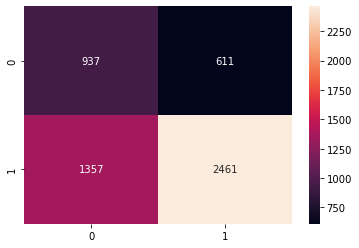

              precision    recall  f1-score   support

         0.0       0.41      0.61      0.49      1548
         1.0       0.80      0.64      0.71      3818

    accuracy                           0.63      5366
   macro avg       0.60      0.62      0.60      5366
weighted avg       0.69      0.63      0.65      5366

Accuracy of LR on training set: 0.63


 ===========   Test Dataset    =============
62.6607043040805
              precision    recall  f1-score   support

         0.0       0.41      0.64      0.50       516
         1.0       0.81      0.62      0.70      1273

    accuracy                           0.63      1789
   macro avg       0.61      0.63      0.60      1789
weighted avg       0.69      0.63      0.64      1789



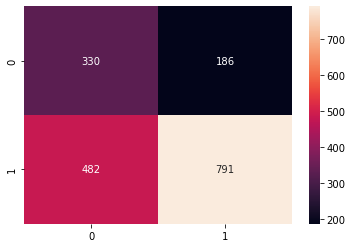

Accuracy of logistic regression on test set: 0.63


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.63953488 0.62136685]
average accuracy:  0.6304508668408264


In [36]:
from sklearn.linear_model import LogisticRegression

#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# cross validation
scores = cross_val_score(logreg, X=X_train, y=Y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

logreg.fit(X_train, Y_train)

pred=logreg.predict(X_test)
pred_train=logreg.predict(X_train)

proba = logreg.predict_proba(X_test)


# for i,val in enumerate(proba):
#     print(proba[i], pred[i], Y_test.to_numpy()[i] )

print("\n \n ===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_lg_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_lg_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = logreg.score(X_train, Y_train)
print('Accuracy of LR on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")

print(accuracy_score(Y_test, pred)*100)

confusion_matrix_lr = confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_lr, annot=True, fmt='g')

print(classification_report(Y_test, pred))
plt.show()

test_acc = logreg.score(X_test, Y_test)
print('Accuracy of logistic regression on test set: {:.2f}'
     .format(test_acc))


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_lr.diagonal()/confusion_matrix_lr.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))

<AxesSubplot:>

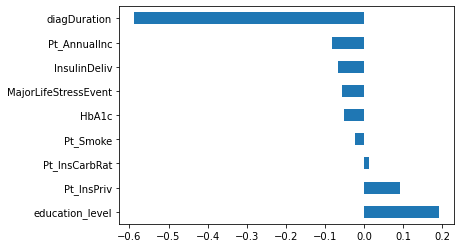

In [37]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 4 - Decision tree

Cross Validation accuracy scores: [0.61266294 0.61452514 0.62942272 0.62756052 0.62197393 0.62197393
 0.61007463 0.62313433 0.5858209  0.60634328]
Cross Validation accuracy: 0.615 +/- 0.012

 
===========   Train Dataset    =============
100.0


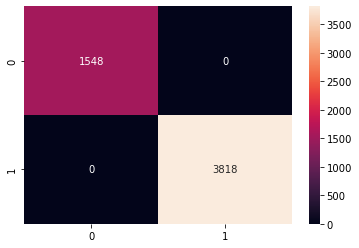

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1548
         1.0       1.00      1.00      1.00      3818

    accuracy                           1.00      5366
   macro avg       1.00      1.00      1.00      5366
weighted avg       1.00      1.00      1.00      5366

Accuracy of XGB on training set: 1.00


 ===========   Test Dataset    =============
62.38121855785354
              precision    recall  f1-score   support

         0.0       0.36      0.39      0.38       516
         1.0       0.74      0.72      0.73      1273

    accuracy                           0.62      1789
   macro avg       0.55      0.56      0.55      1789
weighted avg       0.63      0.62      0.63      1789



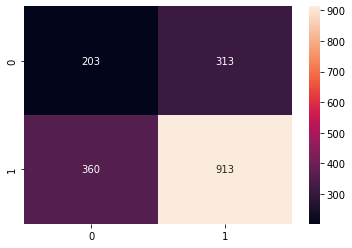

Accuracy of DT on test set: 0.62


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.39341085 0.71720346]
average accuracy:  0.5553071545576889


In [38]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(
                        random_state=0,
                        criterion='gini',
                        splitter = 'best',
                        max_depth = 100,
                        max_features = feature).fit(X_train, Y_train)

# cross validation
scores = cross_val_score(clf, X=X_train, y=Y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))


pred=clf.predict(X_test)
pred_train=clf.predict(X_train)


print("\n \n===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_dt_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_dt_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = clf.score(X_train, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")

print(accuracy_score(Y_test, pred)*100)

confusion_matrix_dt =confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_dt, annot=True, fmt='g')

print(classification_report(Y_test, pred))
plt.show()

test_acc = clf.score(X_test, Y_test)
print('Accuracy of DT on test set: {:.2f}'.format(test_acc))


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_dt.diagonal()/confusion_matrix_dt.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))

<AxesSubplot:>

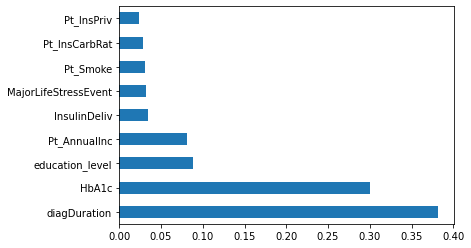

In [39]:

feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 5 - K-Nearest Neighbors

Cross Validation accuracy scores: [0.61080074 0.65549348 0.61266294 0.61638734 0.62756052 0.60893855
 0.58768657 0.60634328 0.61380597 0.61940299]
Cross Validation accuracy: 0.616 +/- 0.016
===========   Train Dataset    =============
100.0


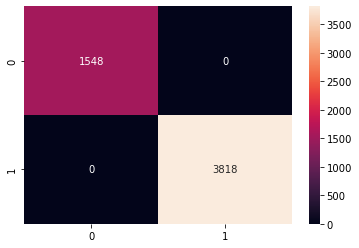

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1548
         1.0       1.00      1.00      1.00      3818

    accuracy                           1.00      5366
   macro avg       1.00      1.00      1.00      5366
weighted avg       1.00      1.00      1.00      5366

Accuracy of XGB on training set: 1.00


 ===========   Test Dataset    =============
61.82224706539966
              precision    recall  f1-score   support

         0.0       0.33      0.32      0.32       516
         1.0       0.73      0.74      0.73      1273

    accuracy                           0.62      1789
   macro avg       0.53      0.53      0.53      1789
weighted avg       0.61      0.62      0.62      1789



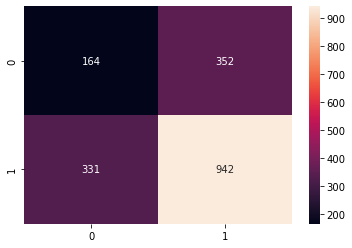

Accuracy of KNN on test set: 0.62


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.31782946 0.73998429]
average accuracy:  0.5289068732226261


In [40]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(
    n_neighbors =1,
    weights = "uniform", # uniform, distance
    algorithm =  'brute', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
)

# cross validation
scores = cross_val_score(knn, X=X_train, y=Y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

knn.fit(X_train, Y_train)


pred=knn.predict(X_test)

pred_train=knn.predict(X_train)


print("===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_dt_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_dt_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = knn.score(X_train, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")

print(accuracy_score(Y_test, pred)*100)

confusion_matrix_knn = confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_knn, annot=True, fmt='g')
print(classification_report(Y_test, pred))
plt.show()

test_acc = knn.score(X_test, Y_test)
print('Accuracy of KNN on test set: {:.2f}'.format(test_acc))


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_knn.diagonal()/confusion_matrix_knn.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))

## Model 6 - Linear Discriminant Analysis

===========   Train Dataset    =============
71.11442415206858


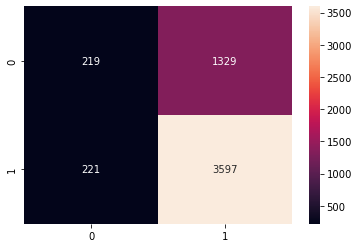

              precision    recall  f1-score   support

         0.0       0.50      0.14      0.22      1548
         1.0       0.73      0.94      0.82      3818

    accuracy                           0.71      5366
   macro avg       0.61      0.54      0.52      5366
weighted avg       0.66      0.71      0.65      5366

Accuracy of XGB on training set: 0.71


 ===========   Test Dataset    =============
72.61039686975964
              precision    recall  f1-score   support

         0.0       0.57      0.19      0.29       516
         1.0       0.74      0.94      0.83      1273

    accuracy                           0.73      1789
   macro avg       0.66      0.57      0.56      1789
weighted avg       0.69      0.73      0.67      1789



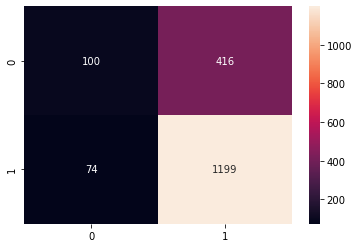

Accuracy of LDA on test set: 0.73


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.19379845 0.9418696 ]
average accuracy:  0.5678340244919832


In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
lda.fit(X_train, Y_train)


pred=lda.predict(X_test)
pred_train=lda.predict(X_train)


print("===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_dt_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_dt_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = lda.score(X_train, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")


print(accuracy_score(Y_test, pred)*100)

confusion_matrix_lda = confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_lda, annot=True, fmt='g')
print(classification_report(Y_test, pred))
plt.show()

test_acc = lda.score(X_test, Y_test)
print('Accuracy of LDA on test set: {:.2f}'
     .format(test_acc))


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_lda.diagonal()/confusion_matrix_lda.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))

## Model 7- Gaussian Naive Bayes

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=0.533669923120631)
===========   Train Dataset    =============
71.18896757361163


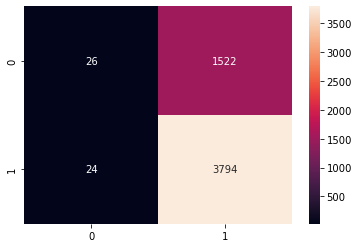

              precision    recall  f1-score   support

         0.0       0.52      0.02      0.03      1548
         1.0       0.71      0.99      0.83      3818

    accuracy                           0.71      5366
   macro avg       0.62      0.51      0.43      5366
weighted avg       0.66      0.71      0.60      5366

Accuracy of XGB on training set: 0.71


 ===========   Test Dataset    =============
71.32476243711571
              precision    recall  f1-score   support

         0.0       0.58      0.02      0.04       516
         1.0       0.71      0.99      0.83      1273

    accuracy                           0.71      1789
   macro avg       0.65      0.51      0.44      1789
weighted avg       0.68      0.71      0.60      1789



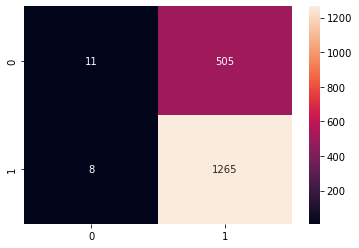

Accuracy of gaussian naive bayes on test set: 0.71


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.02131783 0.99371563]
average accuracy:  0.5075167309109289


In [42]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

gnb = GaussianNB()

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nbModel_grid = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, Y_train)

# best parameters
print(nbModel_grid.best_estimator_)

gnb = GaussianNB(priors=None, var_smoothing=1.0)
gnb.fit(X_train, Y_train)
      
pred=gnb.predict(X_test)

pred_train=gnb.predict(X_train)


print("===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_dt_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_dt_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = gnb.score(X_train, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")


print(accuracy_score(Y_test, pred)*100)

confusion_matrix_gnb = confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_gnb, annot=True, fmt='g')
print(classification_report(Y_test, pred))
plt.show()

test_acc = gnb.score(X_test, Y_test)
print('Accuracy of gaussian naive bayes on test set: {:.2f}'.format(test_acc))


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_gnb.diagonal()/confusion_matrix_gnb.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))

## Model 8 - SVM

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV 1/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.290 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.295 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.705 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.287 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.297 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.295 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.296 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.704 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.708 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.487 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.558 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.385 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.506 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.416 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.464 total time=   0.0s
[CV 2/5] END C=0.1, degree=0

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.451 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.424 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.519 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.567 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.562 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.395 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.511 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.641 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.698 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.692 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.699 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.697 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.702 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.706 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.701 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.695 total time=   0.0s
[CV 4/5] E

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.696 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.672 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.698 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.673 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.499 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.698 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.636 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.695 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.663 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.657 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.692 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.677 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.596 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.697 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.683 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.693 total tim

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.297 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.295 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.292 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.704 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.296 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.704 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.708 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.487 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=0.

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 3/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.484 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.451 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.424 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.519 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.567 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.562 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.395 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.511 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.641 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.698 total time=   0.0s
[CV 3/5] END C=0.

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.706 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.701 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.695 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.556 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.571 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.659 total time=   0.0s
[CV 4/5

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.636 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.695 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.663 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.690 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.708 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.572 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.651 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.672 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.695 total time=   

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.697 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.683 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.693 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.290 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.295 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.705 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.287 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.297 total time=   0.0s
[CV 3/5] END C=0.1, degre

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.708 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.487 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.558 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.385 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.506 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.416 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.464 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.591 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.484 total time=   0.0s
[CV 4/5] END C=0.1, degr

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.698 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.692 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.699 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.697 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.702 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.706 total time=   0.0s
[CV 2/5] E

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.672 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.698 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.673 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.499 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.698 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.636 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.695 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.663 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.690 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.657 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.692 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.677 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.596 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.697 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.683 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.693 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.290 total time=   

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.295 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.292 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.704 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.296 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.704 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.708 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.487 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.558 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.385 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.506 total time=   0.1s
[CV 5/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.416 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.464 total time=   0.1s
[CV 2/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.591 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.484 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.451 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.424 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.519 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.567 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.562 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.395 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.511 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.641 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.698 total time=   0.0s
[CV 3/5] END C=0.1

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.706 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.701 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.695 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.556 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.571 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.659 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.681 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.696 total time=   0.0s
[CV 1

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.698 total time=   0.1s
[CV 1/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.1s
[CV 2/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.636 total time=   0.1s
[CV 3/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.695 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.663 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.690 total time=   0.1s
[CV 1/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.708 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.572 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.651 total time=   0.1s
[CV 4/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.672 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.695 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.657 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.692 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.677 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.596 total tim

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.295 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.293 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.691 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.295 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.294 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.288 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.304 total time=   0.1s
[CV 2/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.705 total time=   0.1s
[CV 3/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.296 total time=   0.1s
[CV 4/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.709 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.305 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.455 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.467 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.545 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.506 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.390 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.553 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.527 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.522 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.451 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=0.1, ker

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.641 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.698 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.692 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.699 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.697 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.702 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 1/5] END C=1, degree=0, ga

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.696 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.672 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.698 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.673 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.499 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.698 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.636 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.695 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.663 total time=   0.0s
[CV 5/5] END C=1, de

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.692 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.677 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.596 total time=   0.1s
[CV 3/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.697 total time=   0.1s
[CV 4/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.683 total time=   0.1s
[CV 5/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.693 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.295 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.293 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.691 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.295 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.294 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.288 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=20

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.545 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.506 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.390 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.553 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.527 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.522 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.451 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.433 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.520 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.573 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.568 total time=   0.1s
[CV 4/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.395 total time=   0.1s
[CV 5/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.419 total time=   0.1s
[CV 1/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.641 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.698 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.692 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.699 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.697 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.702 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.706 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.701 total time=   0.0s
[CV 3/5] END C=1, degree=1, ga

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.681 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.696 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.672 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.698 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.673 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.499 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.698 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.636 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.695 total time=   0.0s
[CV 4/5] END C=1, de

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.657 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.692 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.677 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.596 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.697 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.683 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.693 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.304 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.705 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.296 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.305 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.455 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.467 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.545 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.506 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.1, kernel=rbf, m

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.573 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.568 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.395 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.419 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.641 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.698 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.692 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.699 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.697 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.556 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.571 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.659 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.681 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.696 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.672 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.698 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.673 total time=   0.0s
[CV 4/5] END C=1, degr

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.651 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.672 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.695 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.657 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.692 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.677 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.596 total time=   0.0s
[CV 3/5] E

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.295 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.294 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.288 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.304 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.705 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.296 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.305 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.455 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_ite

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.520 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.573 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.568 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.395 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.419 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.641 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.698 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.692 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.699 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=0

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.695 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.556 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.571 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.659 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.681 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.696 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.672 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.698 total time=   0.0s
[CV 3/5] END C=1, degre

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.708 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.572 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.651 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.672 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.695 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.657 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.692 total time=   0.0s
[CV 1/5] E

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.287 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.293 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.702 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.295 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.294 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.291 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.296 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.706 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.292 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=1, kernel=rbf, 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.342 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.349 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.448 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.625 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.705 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.348 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.651 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.688 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.692 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 4/5] END C=10, degree=0

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 3/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.702 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.596 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.610 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.659 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.681 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.696 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.634 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.650 total time=   0.0s
[CV 3/5] END

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.664 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.690 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.708 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.572 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.651 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.672 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.695 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.1s
[CV 2/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.657 total time=   0.1s
[CV 3/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.1s
[CV 4/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.692 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.677 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.596 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.697 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.683 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.693 total time=   0.0s
[CV 1/5] END C=10, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.295 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.292 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.303 total time=   0.0s
[CV 5/5] END C=10, d

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=10, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.294 total time=   0.0s
[CV 5/5] END C=10, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.291 total time=   0.0s
[CV 1/5] END C=10, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.296 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.706 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.292 total time=   0.0s
[CV 5/5] END C=10, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.286 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.503 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.468 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.704 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.308 total time=   0.0s
[CV 5/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.432 total time=   0.0s
[CV 1/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.471 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.520 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.342 total time=   0.0s
[CV 5/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.349 total time=   0.0s
[CV 1/5] END C=10, degree=1, g

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.705 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.348 total time=   0.0s
[CV 5/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.651 total time=   0.0s
[CV 1/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.688 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.692 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.713 total time=   0.0s
[CV 5/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.699 total time=   0.0s
[CV 1/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 3/5] END C=10, degr

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.702 total time=   0.0s
[CV 1/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.596 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.610 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.659 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.681 total time=   0.0s
[CV 5/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.696 total time=   0.0s
[CV 1/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.634 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.650 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.673 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.499 total time=   0.0s
[CV 5/5] EN

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.572 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.651 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.672 total time=   0.0s
[CV 5/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.695 total time=   0.0s
[CV 1/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.657 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 5/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.692 total time=   0.0s
[CV 1/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.677 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.287 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.293 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.702 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.295 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.294 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.291 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.296 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.706 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.292 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=1, kernel=rbf, 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.342 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.349 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.448 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.625 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.705 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.348 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.651 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.688 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.692 total time=   0.0s
[CV 3/5] END C=10, degree=2,

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.706 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.702 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.596 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.610 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.659 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.681 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.696 total time=   0.0s
[CV 1/5] END C=

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.698 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.677 total time=   0.1s
[CV 2/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.676 total time=   0.1s
[CV 3/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.677 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.664 total time=   0.1s
[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.690 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.708 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.572 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.651 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.672 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.695 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.657 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.692 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.677 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.596 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.697 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.683 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.693 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 2

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 1/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.296 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.706 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.292 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.286 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.503 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.468 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.704 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.308 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.432 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.1,

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.596 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.610 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.659 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.681 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.696 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.634 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.650 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.673 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.499 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.698 total time=   0.0s
[CV 1/5] E

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.657 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.692 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.677 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.596 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.697 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.683 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.693 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=100, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.310 total time=   0.0s
[CV 3/5] END C=100, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.390 total time=   0.0s
[CV 4/5] END C=100, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.298 total time=   0.0s
[CV 5/5] END C=100, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.340 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.662 total time=   0.0s
[CV 2/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.517 total time=   0.0s
[CV 3/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.310 total time=   0.0s
[CV 4/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.703 total time=   0.0s
[CV 5/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.626 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.640 total time=   0.0s
[CV 2/5] END C

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.549 total time=   0.0s
[CV 2/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 3/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.292 total time=   0.0s
[CV 4/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.681 total time=   0.0s
[CV 5/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 2/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.307 total time=   0.0s
[CV 3/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.678 total time=   0.0s
[CV 4/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 5/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.709 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.672 total time=   0.0s
[CV 5/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.695 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s
[CV 2/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.629 total time=   0.0s
[CV 3/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.659 total time=   0.0s
[CV 4/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 5/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.692 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.702 total time=   0.0s
[CV 2/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.705 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.687 total time=   0.1s
[CV 4/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.683 total time=   0.0s
[CV 5/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.693 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.293 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.292 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.294 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.293 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.293 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.706 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.287 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.295 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.295 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=1, k

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 2/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.308 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.405 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.292 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.424 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.347 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.310 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.390 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.298 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.340 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.662 total time=   0.0s
[CV 2/5] END C=100

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.626 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.673 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.679 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.678 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.705 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.587 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.549 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.292 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.681 total time=   0.0s
[CV 5/

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.703 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.707 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.708 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.589 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.651 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.672 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.695 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.629 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.659 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.692 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.702 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.705 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.687 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.683 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.693 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.293 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] E

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.296 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.303 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.286 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.367 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.449 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.380 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.288 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.384 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.322 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.308 total time=   0.0s
[CV 3/5] END C=100, degree

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.292 total time=   0.1s
[CV 5/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.424 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.347 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.310 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.390 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.298 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.340 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.662 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.517 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.310 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.703 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.626 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.640 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.689 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.679 total time=   0.0s
[CV 4/5] END

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.587 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.549 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.292 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.681 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.307 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.678 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.709 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.713 total time=   0.1s
[CV 2/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.703 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.707 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.708 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.589 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.651 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.672 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.695 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.629 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.659 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.692 total tim

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.292 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.294 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.293 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.293 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.706 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.287 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.295 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.295 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.296 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.303 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=1, k

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=100, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.347 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.310 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.390 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.298 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.340 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.662 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.517 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.310 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.703 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.626 total time=   0.0s
[CV 1/5] END C=

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.587 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.549 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.292 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.681 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.307 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.678 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.672 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.695 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.629 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.659 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.675 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.692 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.702 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.705 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.687 total tim

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.293 total time=   0.0s
[CV 4/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.706 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.287 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.295 total time=   0.0s
[CV 2/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.295 total time=   0.0s
[CV 3/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.296 total time=   0.0s
[CV 4/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.303 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.285 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.368 total time=   0.0s
[CV 2/5] END C=1000, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.449 total time=   0.0s
[CV 3/5] END C=1000, degre

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.539 total time=   0.1s
[CV 5/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.673 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.616 total time=   0.1s
[CV 2/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.642 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.396 total time=   0.0s
[CV 4/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.671 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.539 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 2/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.597 total time=   0.0s
[CV 3/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 4/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.505 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.378 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s
[CV 2/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.607 total time= 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.665 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.471 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.708 total time=   0.0s
[CV 2/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.626 total time=   0.0s
[CV 3/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 4/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.714 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.699 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.707 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.302 total time=   0.1s
[CV 3/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.503 total time=   0.0s
[CV 4/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.308 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.637 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.296 total time=   0.0s
[CV 2/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.306 total time=   0.0s
[CV 3/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.657 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.435 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.707 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.293 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.292 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.294 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.293 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.293 total time=   0.0s
[CV 4/5] END C=1000,

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.380 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.288 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.336 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.330 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.339 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.448 total time=   0.1s
[CV 4/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.295 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.323 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.337 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.349 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.450 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.297 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.529 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.507 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.570 total time=   0.0s
[CV 3/5]

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.639 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.539 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.673 total time=   0.1s
[CV 1/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.616 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.642 total time=   0.1s
[CV 3/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.396 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.671 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.539 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.597 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.505 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.378 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.703 total time=  

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 5/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.490 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.676 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.610 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.708 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.665 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.471 total time=   0.1s
[CV 1/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.708 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.626 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.714 tota

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.699 total time=   0.1s
[CV 1/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.707 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.302 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.503 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.308 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.637 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.296 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.306 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.657 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.435

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.293 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.292 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.294 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.293 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.293 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.706 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.287 total time=   0.0s
[CV 1/5] END C=1000, degree=2,

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.449 total time=   0.1s
[CV 3/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.380 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.288 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.336 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.330 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.339 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.448 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.295 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.323 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.337 total time=   0.0s
[CV 2/5] E

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.507 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.570 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.484 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.682 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.636 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.642 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.470 total time=   0.1s
[CV 3/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.639 total time=   0.1s
[CV 4/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.539 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.673 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.616 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.642 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.396 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.671 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.539 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.597 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.505 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.378 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.607 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.393 total time=

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.708 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.626 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.714 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.699 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.707 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.302 total time=   0.1s
[CV 3/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.503 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.308 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.637 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.296 total time=   0.1s
[CV 2/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.306 total time=   0.1s
[CV 3/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.657 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.435 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.707 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.293 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.292 total time=   0.0s
[CV 1

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.706 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.287 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.295 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.295 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.296 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.303 total time=   0.1s
[CV 5/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.285 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.368 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.449 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.380 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.288 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.336 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.330 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.339 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.448 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.295 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.323 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.337 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.349 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.450 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.297 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.529 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.507 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.570 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.484 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.682 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.636 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.642 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.470 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.639 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.539 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.673 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.505 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.378 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.607 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.393 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.697 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.490 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.676 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.610 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.708 total tim

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.503 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.308 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.637 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.296 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.306 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.657 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.435 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.707 total time=   0.0s
{'C': 100, 'degree': 0, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': 20}
SVC(C=100, degree=0, gamma=0.001, max_iter=20)
===========   Train Dataset    =============
63.995527394707416


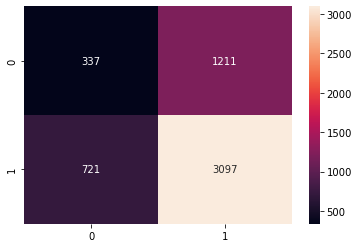

              precision    recall  f1-score   support

         0.0       0.32      0.22      0.26      1548
         1.0       0.72      0.81      0.76      3818

    accuracy                           0.64      5366
   macro avg       0.52      0.51      0.51      5366
weighted avg       0.60      0.64      0.62      5366

Accuracy of XGB on training set: 0.64
65.0642817216322
              precision    recall  f1-score   support

         0.0       0.36      0.27      0.31       516
         1.0       0.73      0.80      0.77      1273

    accuracy                           0.65      1789
   macro avg       0.55      0.54      0.54      1789
weighted avg       0.62      0.65      0.63      1789



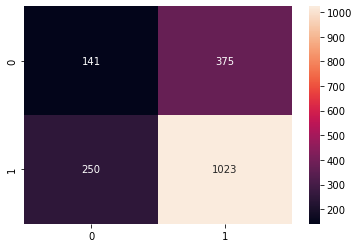

Accuracy of svm on test set: 0.65


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.27325581 0.80361351]
average accuracy:  0.5384346626719524


In [43]:
from sklearn.svm import SVC
# svm = SVC(
#     C = 10, # Cfloat, default=1.0
#     kernel = 'sigmoid', #kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
#     degree = 5, #degree, default=3
#     gamma = 0.1, #gamma{‘scale’, ‘auto’} or float, default=’scale’
#     class_weight = None, # ‘balanced’, default=None
#     max_iter = 15,
# #     decision_function_shape = 'ovo' # {‘ovo’, ‘ovr’}, default=’ovr’
# )

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'degree': [0,1,2,3],
              'max_iter': [10,15,20],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train, Y_train)

# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

svm = SVC(C = grid.best_params_['C'],
         gamma = grid.best_params_['gamma'],
         degree = grid.best_params_['degree'],
         max_iter = grid.best_params_['max_iter'],
         kernel = grid.best_params_['kernel']
         )

svm.fit(X_train, Y_train)

pred=svm.predict(X_test)
pred_train=svm.predict(X_train)


print("===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_dt_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_dt_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = svm.score(X_train, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print(accuracy_score(Y_test, pred)*100)

confusion_matrix_svm = confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_svm, annot=True, fmt='g')
print(classification_report(Y_test, pred))
plt.show()

test_acc = svm.score(X_test, Y_test)
print('Accuracy of svm on test set: {:.2f}'.format(test_acc))

print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_svm.diagonal()/confusion_matrix_svm.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))